In [1]:
import torch.nn as nn
import torch
import pytorch_lightning as pl
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

DATASET_PATH = "../../data"

from mnist_deep_nf import * 

/apps/conda/joao.pires/.envs/jpt_main/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Seed set to 42


In [2]:
pretrained_filename = 'saved_models/MNISTFlow_deep01/lightning_logs/version_11366/checkpoints/epoch=244-step=95550.ckpt'
ckpt = torch.load(pretrained_filename, map_location=device)

In [3]:
flow = create_multiscale_flow()

In [4]:
flow.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [14]:
def show_imgs_save(imgs, title=None, row_size=8, fig_name = None):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = imgs.dtype==torch.int32 if isinstance(imgs, torch.Tensor) else imgs[0].dtype==torch.int32
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128 if is_int else 0.5)
    np_imgs = imgs.cpu().numpy()/255
    # Plot the grid
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.tight_layout()

    plt.savefig('images/generated_mnist.png', format = 'png')
    plt.show()
    plt.close()

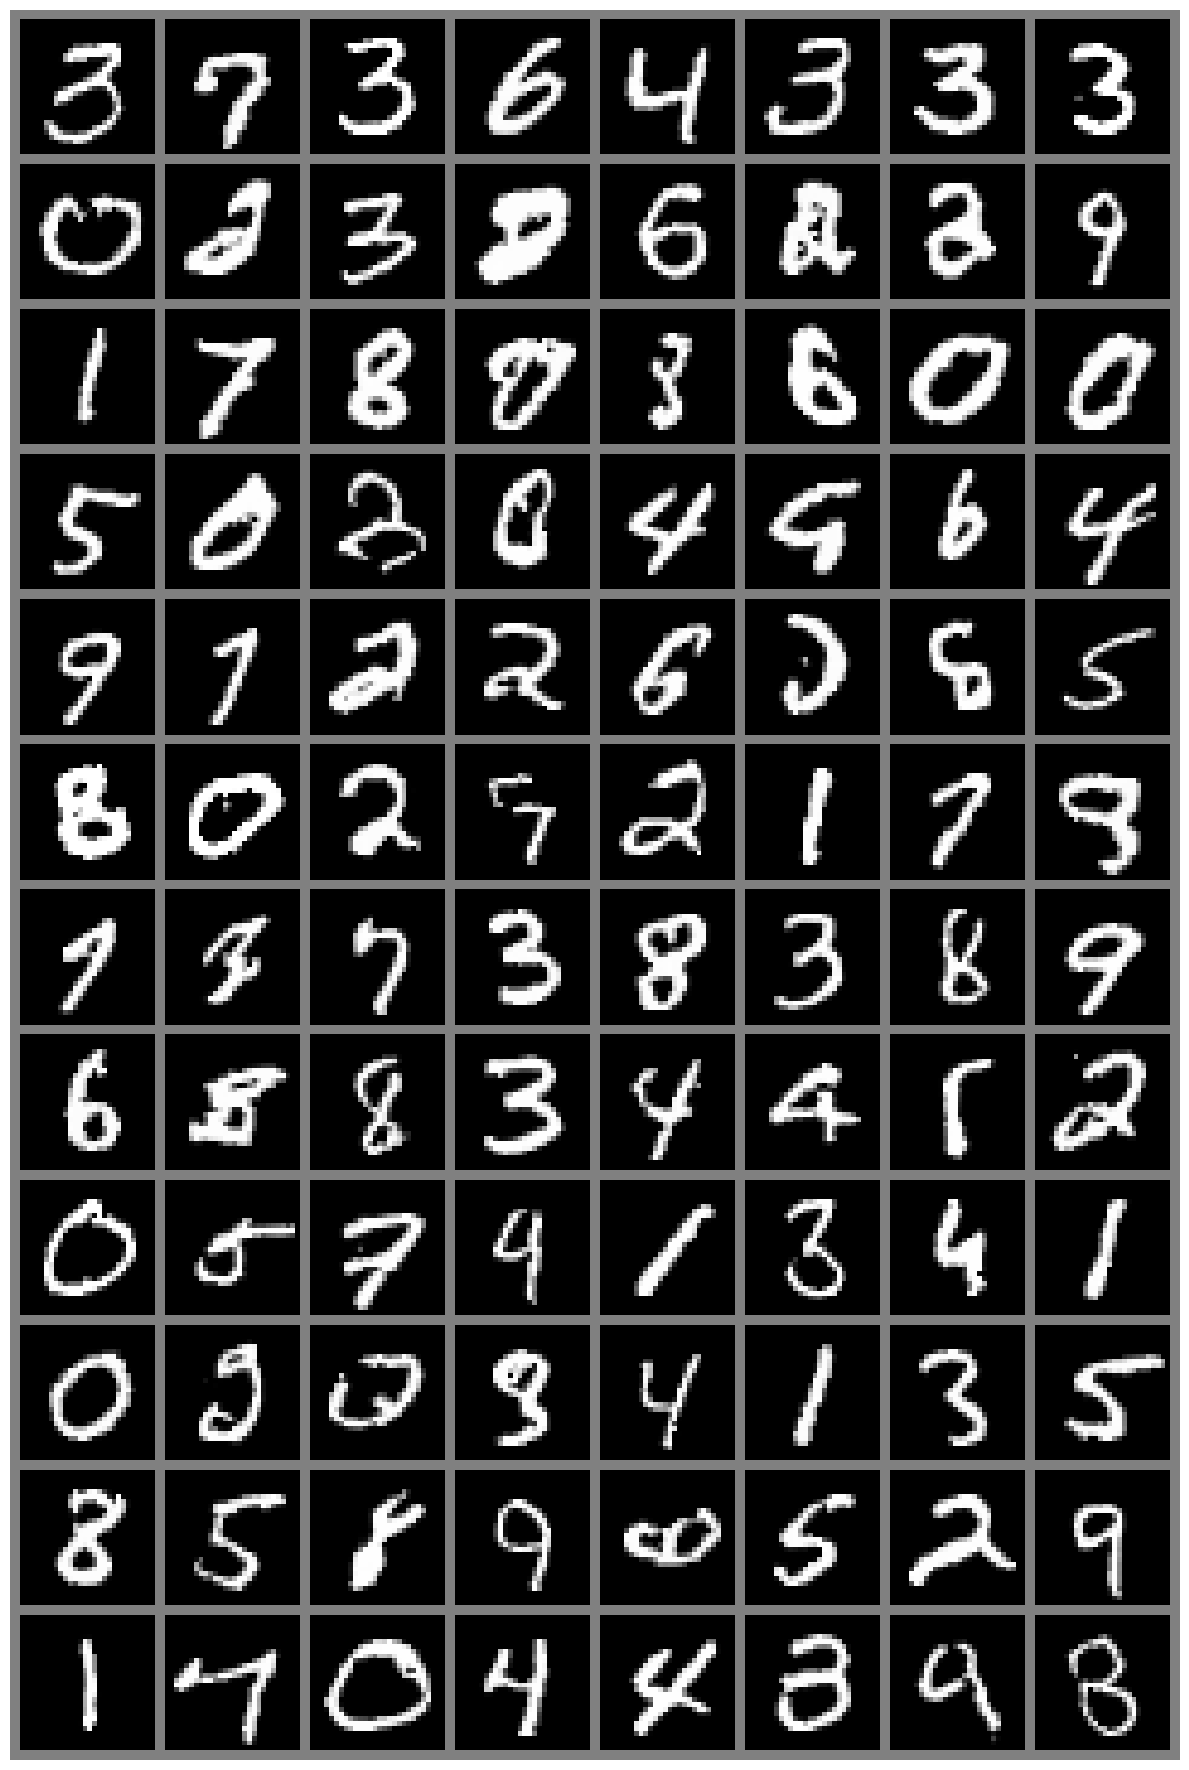

In [21]:
samples = flow.sample(img_shape=[96,8,7,7])
show_imgs_save(samples.cpu())

In [7]:
flow.eval()

likelihoods = []
test_dic = {}

for i in range(10):
    test_dic[f'{i}'] = {'ll' : [], 'img' : [], 'bpd' : []}
    


for image, label in test_set:
    
    image = image.to(device)
    image = image.view(1,1,28,28)
    
    with torch.no_grad():
        ll = flow._get_likelihood(image, return_ll = True).item()
        bpd = flow._get_likelihood(image, return_ll = False).item()
        likelihoods.append(ll)
    
    image = image.view(1,28,28)
    label = str(label)
    test_dic[label]['ll'].append(ll)
    test_dic[label]['bpd'].append(bpd)
    test_dic[label]['img'].append(image.to('cpu'))

import pickle

with open('test_dic.pkl', 'wb') as fp:
    pickle.dump(test_dic, fp)

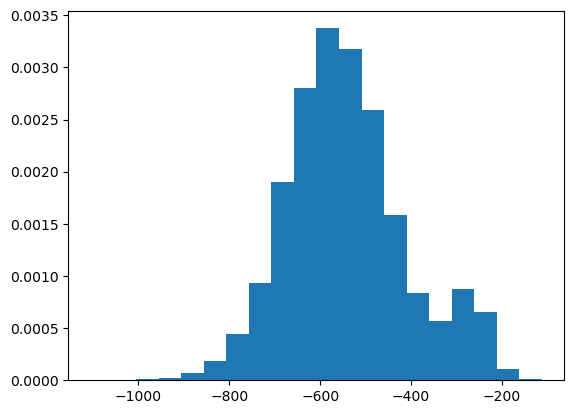

In [8]:
plt.hist(likelihoods, bins = 20, density = True);

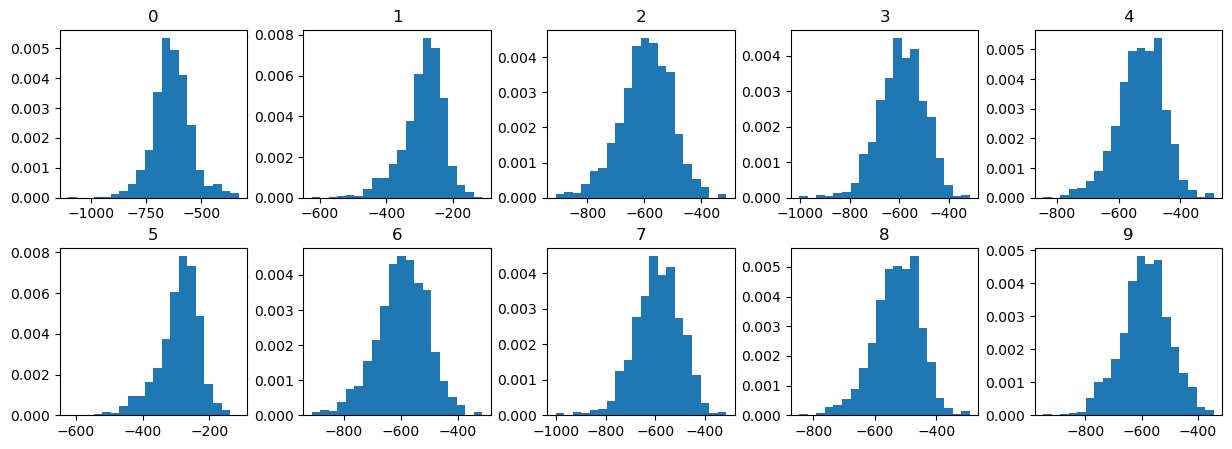

In [9]:
fig, ax = plt.subplots(ncols = 5, nrows = 2, figsize = (15,5))

idx1 = 0
for i in range(2):
    for j in range(5):
        ax[i,j].hist(test_dic[str(i+j)]['ll'], bins = 20, density = True);
        ax[i,j].set_title(idx1);
        idx1+=1

plt.subplots_adjust(wspace = 0.3, hspace = 0.3) 


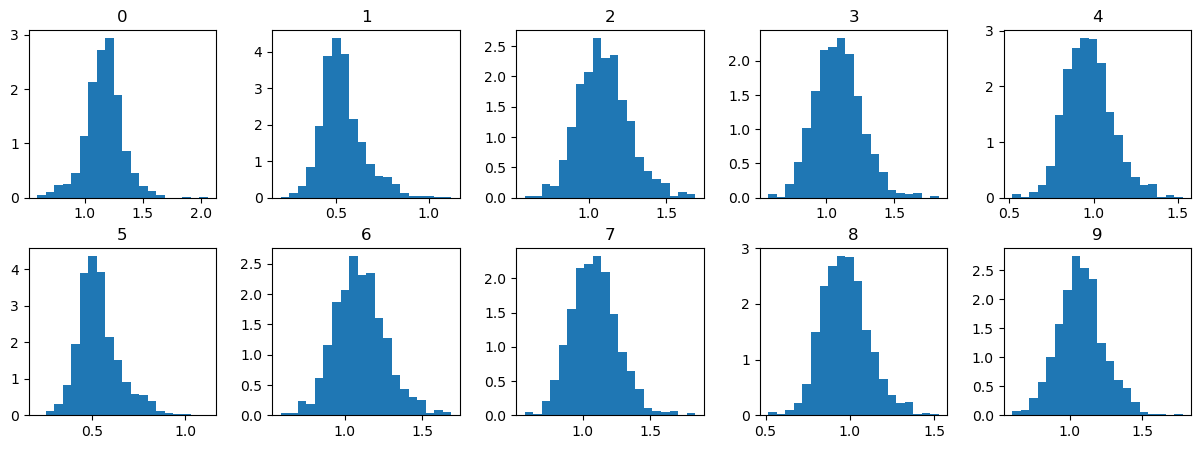

In [10]:
fig, ax = plt.subplots(ncols = 5, nrows = 2, figsize = (15,5))

idx1 = 0
for i in range(2):
    for j in range(5):
        ax[i,j].hist(test_dic[str(i+j)]['bpd'], bins = 20, density = True);
        ax[i,j].set_title(idx1);
        idx1+=1

plt.subplots_adjust(wspace = 0.3, hspace = 0.3) 


In [11]:
number_of_anomalous = 50

top_anomalous = torch.zeros(size = (number_of_anomalous*10, 1, 28, 28))

j = 0

for i in range(10):
    
    pos = np.argsort(test_dic[str(i)]['ll'])[:number_of_anomalous]

    for element in (pos):
        top_anomalous[j] = test_dic[str(i)]['img'][element]
        j += 1
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


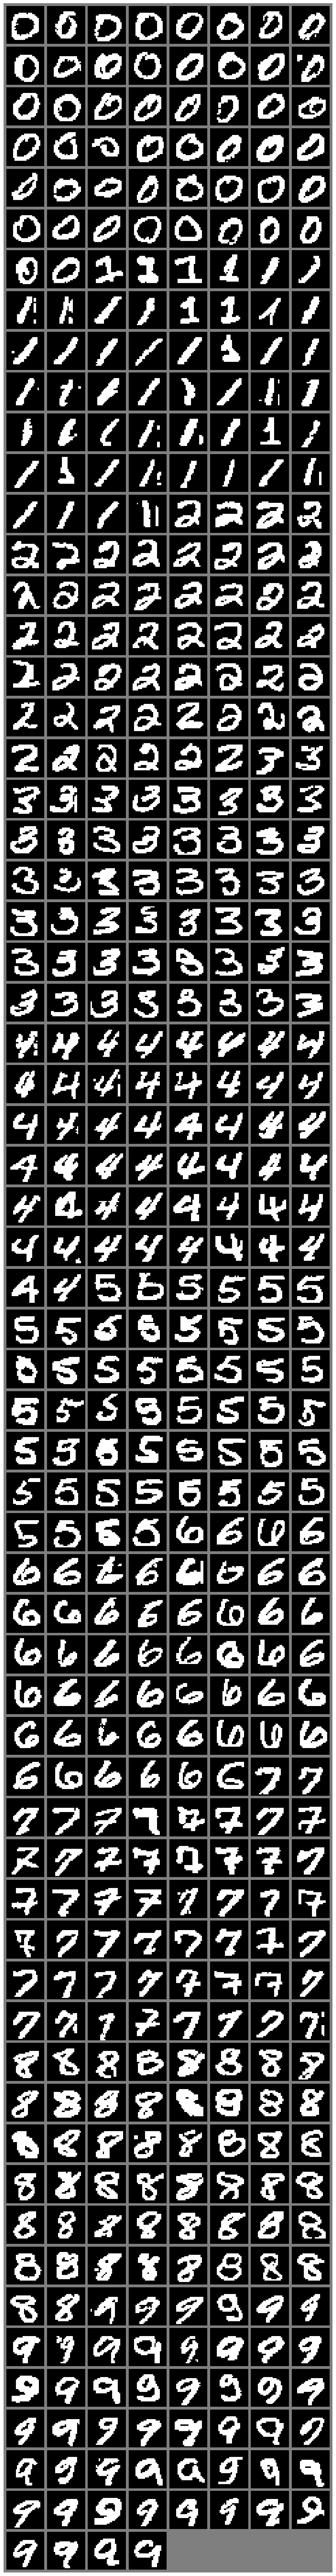

In [12]:
show_imgs(top_anomalous)

In [ ]:
flow.eval()

train_dic = {}

for i in range(10):
    train_dic[f'{i}'] = {'ll' : [], 'img' : [], 'bpd' : []}
    


for image, label in train_dataset:
    
    image = image.to(device)
    image = image.view(1,1,28,28)
    
    with torch.no_grad():
        ll = flow._get_likelihood(image, return_ll = True).item()
        bpd = flow._get_likelihood(image, return_ll = False).item()
        likelihoods.append(ll)
    
    image = image.view(1,28,28)
    label = str(label)
    train_dic[label]['ll'].append(ll)
    train_dic[label]['bpd'].append(bpd)
    train_dic[label]['img'].append(image.to('cpu'))

import pickle

with open('train_dic.pkl', 'wb') as fp:
    pickle.dump(train_dic, fp)